# Convolution Neural Network

In this lab, we introduce two datasets, **MNIST** and **CIFAR**, then we will talk about how to implement CNN models for these two datasets using tensorflow. The major difference between mnist and cifar is their size. Due to the limit of memory size and time issue, we offer a guide to illustrate typical **input pipeline** of tensorflow. Let's dive into tensorflow!



In [1]:
import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## MNIST
We start from a simple dataset. MNIST is a simple computer vision dataset. It consists of images of handwritten digits like:

![](https://nthu-datalab.github.io/ml/labs/12-1_CNN/imgsrc/MNIST.png)

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1. Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

![](https://nthu-datalab.github.io/ml/labs/12-1_CNN/imgsrc/MNIST2.png)

The MNIST data is hosted on [Yann LeCun's](http://yann.lecun.com/exdb/mnist/) website. We can directly import MNIST dataset from Tensorflow.


In [5]:
# Download and prepare the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
print('shape of train_images:', train_images.shape)
print('shape of train_labels:', train_labels.shape)

11493376/11490434 [==============================] - 3s 0us/step
shape of train_images: (60000, 28, 28)
shape of train_labels: (60000,)


## Softmax Regression on MNIST
Before jumping to *Convolutional Neural Network* model, we're going to start with a very simple model with a single layer and softmax regression.

We know that every image in MNIST is a handwritten digit between zero and nine. So there are only ten possible digits that a given image can be. We want to give the probability of the input image for being each digit. That is, input an image, the model outputs a ten-dimension vector.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do.



In [6]:
# flating the training data for dense layers
train_images_1 = train_images.reshape((60000, -1))
test_images_1 = test_images.reshape((10000, -1))
print(train_images_1.shape)
print(test_images_1.shape)


(60000, 784)
(10000, 784)


In [7]:
model_1 = models.Sequential()
model_1.add(layers.Dense(10, activation='softmax',input_shape=(784,)))
model_1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compile the model and train it for 5 epochs
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_1.fit(train_images_1, train_labels, epochs=5)


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4692 - accuracy: 0.8762
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3031 - accuracy: 0.9151
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2834 - accuracy: 0.9211
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2729 - accuracy: 0.9238
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2667 - accuracy: 0.9249


In [9]:
_, test_acc_1 = model_1.evaluate(test_images_1, test_labels, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_1)


Testing Accuracy : 0.9276


From the above result, we got about 92.6% accuracy for Softmax Regression on MNIST. In fact, it's not so good. This is because we're using a very simple model.



## Multilayer Convolutional Network on MNIST

We're now jumping from a very simple model to something moderately sophisticated: a small *Convolutional Neural Network.* This will get us to over 99% accuracy, not state of the art, but respectable.



In [12]:
# reshaping the training data to 3 dimensions
train_images_2 = train_images.reshape((60000, 28, 28, 1))
test_images_2 = test_images.reshape((10000, 28, 28, 1))
print(train_images_2.shape)
print(test_images_2.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Create the convolutional base
As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to color channels, MNIST has one (because the images are grayscale), whereas a color image has three (R,G,B). In this example, we will configure our CNN to process inputs of shape (28, 28, 1), which is the format of MNIST images. We do this by passing the argument **input_shape** to our first layer.



In [13]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))


Let's display the architecture of our model so far.

In [14]:
model_2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top
To complete our model, we will feed the last output tensor from the convolutional base (of shape (3, 3, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will **flatten** (or unroll) the 3D output to 1D, then **add one or more Dense layers on top.** MNIST has 10 output classes, so we use a final Dense layer with 10 outputs and a softmax activation.

To reduce overfitting, we will apply [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) before the readout layer. 

The idea behind dropout is to train an ensemble of model instead of a single model. During training, we drop out neurons with probability 
$p$
, i.e., the probability to keep is 
$1
−
p$
. When a neuron is dropped, its output is set to zero. These dropped neurons do not contribute to the training phase in forward pass and backward pass. For each training phase, we train the network slightly different from the previous one. It's just like we train different networks in each training phrase. However, during testing phase, we don't drop any neuron, and thus, implement dropout is kind of like doing ensemble. Also, randomly drop units in training phase can prevent units from co-adapting too much. Thus, dropout is a powerful regularization techique to deal with overfitting.



In [15]:
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(10, activation='softmax'))


In [16]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576) before going through two Dense layers.

### Compile and train the model


In [17]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.fit(train_images_2, train_labels, epochs=5)


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2751 - accuracy: 0.9165
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0938 - accuracy: 0.9740
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0658 - accuracy: 0.9819
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0519 - accuracy: 0.9852
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0447 - accuracy: 0.9873


In [18]:
_, test_acc_2 = model_2.evaluate(test_images_2, test_labels, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_2)


Testing Accuracy : 0.9899


As you can see, our simple CNN has achieved a test accuracy of over 99%. Not bad for a few lines of code! For another style of writing a CNN (using the Keras Subclassing API and a GradientTape) head here.



# Cifar-10
Actually MNIST is a easy dataset for the beginner. To demonstrate the power of Neural Networks, we need a larger dataset CIFAR-10.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Here are the classes in the dataset, as well as 10 random images from each:

![](https://nthu-datalab.github.io/ml/labs/12-1_CNN/imgsrc/CIFAR10.png)


Before jumping to a complicated neural network model, we're going to start with KNN and SVM. The motivation here is to compare neural network model with traditional classifiers, and highlight the performance of neural network model.

tf.keras.datasets offers convenient facilities that automatically access some well-known datasets. Let's load the CIFAR-10 in tf.keras.datasets:



In [19]:
# Loading Data
import math

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# convert class vectors to binary vectors
Y_train = utils.to_categorical(y_train)
Y_test = utils.to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)


X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


For simplicity, we also convert the images into the grayscale. We use the [Luma coding](https://en.wikipedia.org/wiki/Grayscale#Luma_coding_in_video_systems) that is common in video systems:



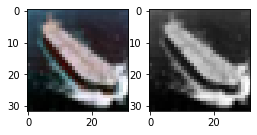

In [20]:
# transform a 3-channel image into one channel
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r = np.asarray(.3, dtype=dtype)
    g = np.asarray(.59, dtype=dtype)
    b = np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# plot a randomly chosen image
img = round(np.random.rand() * X_train.shape[0])
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(
    X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()


As we can see, the objects in grayscale images can still be recognizable.

## Feature Selection
When coming to object detection, HOG (histogram of oriented gradients) is often extracted as a feature for classification. It first calculates the gradients of each image patch using sobel filter, then use the magnitudes and orientations of derived gradients to form a histogram per patch (a vector). After normalizing these histograms, it concatenates them into one HOG feature. For more details, read this [tutorial](https://www.learnopencv.com/histogram-of-oriented-gradients/).

> Note. one can directly feed the original images for classification; however, it will take lots of time to train and get worse performance.



In [24]:
def getHOGfeat(image,
               stride=8,
               orientations=8,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2)):
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    sx, sy, sz = image.shape
    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    gx = np.zeros((sx, sy), dtype=np.double)
    gy = np.zeros((sx, sy), dtype=np.double)
    eps = 1e-5
    grad = np.zeros((sx, sy, 2), dtype=np.double)
    for i in range(1, sx - 1):
        for j in range(1, sy - 1):
            gx[i, j] = image[i, j - 1] - image[i, j + 1]
            gy[i, j] = image[i + 1, j] - image[i - 1, j]
            grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
            if gx[i, j] < 0:
                grad[i, j, 0] += 180
            grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
            grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
    for y in range(n_blocksy):
        for x in range(n_blocksx):
            block = grad[y * stride:y * stride + 16, x * stride:x * stride + 16]
            hist_block = np.zeros(32, dtype=np.double)
            eps = 1e-5
            for k in range(by):
                for m in range(bx):
                    cell = block[k * 8:(k + 1) * 8, m * 8:(m + 1) * 8]
                    hist_cell = np.zeros(8, dtype=np.double)
                    for i in range(cy):
                        for j in range(cx):
                            n = int(cell[i, j, 0] / 45)
                            hist_cell[n] += cell[i, j, 1]
                    hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
            normalised_blocks[y, x, :] = hist_block / np.sqrt(
                hist_block.sum() ** 2 + eps)
    return normalised_blocks.ravel()


Once we have our *getHOGfeat* function, we then get the HOG features of all images.

In [25]:
X_train_hog = []
X_test_hog = []

print('This will take some minutes.')

for img in X_train_gray:
    img_hog = getHOGfeat(img)
    X_train_hog.append(img_hog)

for img in X_test_gray:
    img_hog = getHOGfeat(img)
    X_test_hog.append(img_hog)

X_train_hog_array = np.asarray(X_train_hog)
X_test_hog_array = np.asarray(X_test_hog)


This will take some minutes.


## K Nearest Neighbors (KNN) on CIFAR-10
scikit-learn provides off-the-shelf libraries for classification. For KNN and SVM classifiers, we can just import from scikit-learn to use.

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

# p=2 and metric='minkowski' means the Euclidean Distance
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')

knn.fit(X_train_hog_array, y_train.ravel())
y_pred = knn.predict(X_test_hog_array)
print('[KNN]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


We can observe that the accuracy of KNN on CIFAR-10 is embarrassingly bad.



## Support Vector Machine (SVM) on CIFAR-10


In [ ]:
# SVM
from sklearn.svm import SVC 

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_linear = SVC(kernel='linear', random_state=0, gamma=0.2, C=10.0)

svm_linear.fit(X_train_hog_array, y_train.ravel())
y_pred = svm_linear.predict(X_test_hog_array)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test.ravel(), y_pred))


## CNN on CIFAR-10
By above, SVM is slightly better than KNN, but still poor. Next, we'll design a CNN model using tensorflow.


In [ ]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_3 = models.Sequential()
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
                
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
                
model_3.add(layers.Flatten())
model_3.add(layers.Dense(384, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(192, activation='relu'))
model_3.add(layers.Dense(10, activation='softmax'))
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.fit(X_train, y_train, epochs=200,validation_data=(X_test, y_test),verbose=0)


In [ ]:
_, test_acc_3 = model_3.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_3)


Although Cifar10 is larger than Mnist, it's not large enough for the dataset you will meet in the following lessons. For large datasets, we can't feed all training data to the model due to the limit of memory size. Even if we can feed all data into the model, we still want the process of loading data is efficient. **Input pipeline** is the common way to solve these.

## Input Pipeline
### Structure of an input pipeline
A typical TensorFlow training input pipeline can be framed as an ETL process:

1. Extract: Read data from memory (NumPy) or persistent storage -- either local (HDD or SSD) or remote (e.g. GCS or HDFS).
2. Transform: Use CPU to parse and perform preprocessing operations on the data such as shuffling, batching, and domain specific transformations such as image decompression and augmentation, text vectorization, or video temporal sampling.
3. Load: Load the transformed data onto the accelerator device(s) (e.g. GPU(s) or TPU(s)) that execute the machine learning model.
This pattern effectively utilizes the CPU, while reserving the accelerator for the heavy lifting of training your model. In addition, viewing input pipelines as an ETL process provides a framework that facilitates the application of performance optimizations.

### tf.data API
To build a data input pipeline with **tf.data**, here are the steps that you can follow:

1. Define data source and initialize your Dataset object
2. Apply transformations on the dataset, following are some common useful  techniques
    * map
    * shuffle
    * batch
    * repeat
    * prefetch
3. Create iterator

### Construct your Dataset
To create an input pipeline, you must start with a data source. For example, to construct a **Dataset** from data in memory, you can use ```tf.data.Dataset.from_tensors()``` or ```tf.data.Dataset.from_tensor_slices()```. Alternatively, if your input data is stored in a file in the recommended TFRecord format, you can use ```tf.data.TFRecordDataset()```.

Once you have a **Dataset** object, you can transform it into a new Dataset by chaining method calls on the **tf.data.Dataset** object. For example, you can apply per-element transformations such as **Dataset.map()**, and multi-element transformations such as **Dataset.batch()**. See the documentation for **tf.data.Dataset** for a complete list of transformations.

Now suppose we have simple data sources:



In [26]:
# number of samples
n_samples = 200

# an array with shape (n_samples, 5)
raw_data_a = np.random.rand(n_samples, 5)
# a list with length of n_samples from 0 to n_samples-1
raw_data_b = np.arange(n_samples)


We can create our tensorflow Dataset object with these two data using **tf.data.Dataset.from_tensor_slices**, which will automatically cut your data into slices:

In [27]:
# this tells the dataset that each row of raw_data_a is corresponding to each element of raw_data_b
raw_dataset = tf.data.Dataset.from_tensor_slices((raw_data_a, raw_data_b))
print(raw_dataset)


<TensorSliceDataset shapes: ((5,), ()), types: (tf.float64, tf.int32)>


#### Apply transformations
Next, according to your needs, you can preprocess your data in this step.

**map**
For example, **Dataset.map()** provide element-wise customized data preprocessing.



In [28]:
def preprocess_function(one_row_a, one_b):
    """
        Input: one slice of the dataset
        Output: modified slice
    """
    # Do some data preprocessing, you can also input filenames and load data in here
    # Here, we transform each row of raw_data_a to its sum and mean
    one_row_a = [tf.reduce_sum(one_row_a), tf.reduce_mean(one_row_a)]

    return one_row_a, one_b


In [29]:
raw_dataset = raw_dataset.map(preprocess_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
print(raw_dataset)


<ParallelMapDataset shapes: ((2,), ()), types: (tf.float64, tf.int32)>


#### shuffle
**Dataset.shuffle(buffer_size)** maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer. This way, you can see your data coming with different order in different epoch. This can prevent your model overfit on the order of your training data.



In [30]:
dataset = raw_dataset.shuffle(16)

#### batch
Now our dataset is one example by one example. However, in reality, we usually want to read one batch at a time, thus we can call **Dataset.batch(batch_size)** to stack batch_size elements together.

**Note:** Be careful that if you apply **Dataset.shuffle** after **Dataset.batch**, you'll get shuffled batch but data in a batch remains the same.



In [31]:
dataset = dataset.batch(2,drop_remainder=False)


#### repeat
Repeats this dataset count times.

**Dataset.repeat(count)** allow you iterate over a dataset in multiple epochs. **count = None or -1** will let the dataset repeats indefinitely.



In [32]:
dataset = dataset.repeat(2)

If you would like to perform a custom computation (e.g. to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [33]:
epochs = 3
cus_dataset = raw_dataset.batch(32)

for epoch in range(epochs):
    size = 0
    for batch in cus_dataset:
        size += 1
    print("End of epoch: %d, Batch size of this epoch: %d"%(epoch, size))


End of epoch: 0, Batch size of this epoch: 7
End of epoch: 1, Batch size of this epoch: 7
End of epoch: 2, Batch size of this epoch: 7


#### prefetch
Creates a Dataset that prefetches elements from this dataset.

**Dataset.prefetch(buffer_size)** allow you decouple the time when data is produced from the time when data is consumed.

In [34]:
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


#### Consume elements
The **Dataset** object is a Python iterable. This makes it possible to consume its elements using a for loop:



In [35]:
# Here, we print the first 8 batches.
for i,elem in enumerate(dataset):
    print("Batch ", i, ", b are ", elem[1].numpy())
    if i==8:
        break

Batch  0 , b are  [11 15]
Batch  1 , b are  [1 2]
Batch  2 , b are  [8 0]
Batch  3 , b are  [10  7]
Batch  4 , b are  [22 16]
Batch  5 , b are  [ 6 13]
Batch  6 , b are  [21 28]
Batch  7 , b are  [ 5 19]
Batch  8 , b are  [26 18]


Or by explicitly creating a Python iterator using **iter** and consuming its elements using **next**:

In [36]:
# Here, we print the first 8 batches.
it = iter(dataset)
for i in range(8):
    print("Batch ", i, ", b are ", next(it)[1].numpy())


Batch  0 , b are  [11  3]
Batch  1 , b are  [0 7]
Batch  2 , b are  [15 16]
Batch  3 , b are  [9 2]
Batch  4 , b are  [21 23]
Batch  5 , b are  [18 24]
Batch  6 , b are  [27 26]
Batch  7 , b are  [5 6]


#### repeat+batch / batch+repeat
The Dataset.repeat transformation concatenates its arguments without signaling the end of one epoch and the beginning of the next epoch. Because of this a Dataset.batch applied after Dataset.repeat will yield batches that stradle epoch boundaries:

In [38]:
# use this function to plot the size of each batch.
def plot_batch_sizes(ds,title):
    batch_sizes = [batch[1].shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')
    plt.title(title)
    plt.show()


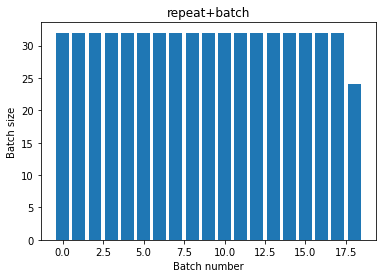

In [39]:
# plot the bar diagram of repeat+batch
repeat_batch_ds = raw_dataset.repeat(3).batch(32)
plot_batch_sizes(repeat_batch_ds,'repeat+batch')


If you need clear epoch separation, put Dataset.batch before the repeat:

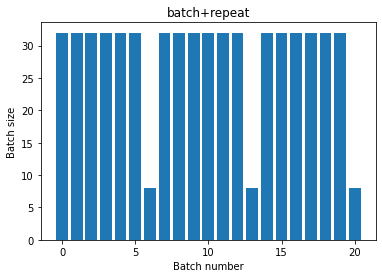

In [40]:
# plot the bar diagram of batch+repeat
batch_repeat_ds = raw_dataset.batch(32).repeat(3)
plot_batch_sizes(batch_repeat_ds,'batch+repeat')

#### shufflt+repeat / repeat+shufflt
As with Dataset.batch the order relative to Dataset.repeat matters.

Dataset.shuffle doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next.

But a repeat before a shuffle mixes the epoch boundaries together.



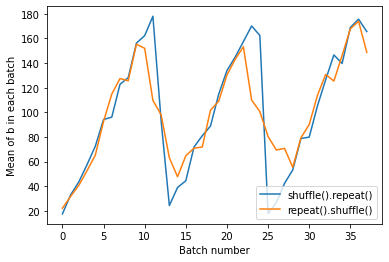

In [41]:
# You can find that a repeat before a shuffle mixes the epoch boundaries in this graph.
shuffle_repeat_ds = raw_dataset.shuffle(32).repeat(3).batch(16)
repeat_shuffle_ds = raw_dataset.repeat(3).shuffle(32).batch(16)

shuffle_repeat = [batch[1].numpy().mean() for batch in shuffle_repeat_ds]
repeat_shuffle = [batch[1].numpy().mean() for batch in repeat_shuffle_ds]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.xlabel('Batch number')
plt.ylabel("Mean of b in each batch")
plt.legend()


Now, let's start designing our cnn model!

## CNN Model for CIFAR 10
### Loading Data Manually
To know how it works under the hood, let's load CIFAR-10 by our own (not using tf.keras). According the descripion, the dataset file is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class.



In [42]:
import pickle

# the url to download CIFAR-10 dataset (binary version)
# see format and details here: http://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# the image size we want to keep
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

In [43]:
# donwnload data
cifar10 = utils.get_file('cifar-10-python.tar.gz',
                                  cache_subdir=os.path.abspath('.'),
                                  origin = DATA_URL,
                                  extract = True)
DEST_DIRECTORY = os.path.join(os.path.dirname(cifar10),'cifar-10-batches-py')
filenames_train = [os.path.join(DEST_DIRECTORY,'data_batch_%d' % i) for i in range(1,6)]
filenames_test = [os.path.join(DEST_DIRECTORY,'test_batch')]

170500096/170498071 [==============================] - 576s 3us/step


In [44]:
# read data
def unpickle(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

# parse training data
def map_fun(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(
        distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
def map_fun_test(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label


In [45]:
X_train = None
Y_train = None
X_test = None
Y_test = None

for filename in filenames_train:
    images,labels = unpickle(filename)
    X_train = images if X_train is None else np.concatenate((X_train,images))
    Y_train = labels if Y_train is None else np.concatenate((Y_train,labels))

for filename in filenames_test:
    images,labels = unpickle(filename)
    X_test = images if X_test is None else np.concatenate((X_test,images))
    Y_test = labels if Y_test is None else np.concatenate((Y_test,labels))

# Construct training Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
dataset = dataset.map(map_fun)
dataset = dataset.shuffle(10000)
dataset = dataset.batch(64)

# # Construct testing Dataset
dataset_test = tf.data.Dataset.from_tensor_slices((X_test,Y_test))
dataset_test = dataset_test.map(map_fun_test)
dataset_test = dataset_test.batch(64)


In [46]:
model_cifar = models.Sequential()

model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Flatten())
model_cifar.add(layers.Dense(384, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(192, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(10, activation='softmax'))


In [47]:
model_cifar.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_cifar.fit(dataset, epochs=200, validation_data=dataset_test, verbose=0)


We have done our training! Let's see whether our model is great or not.

In [48]:
_, test_acc = model_cifar.evaluate(dataset_test, verbose=0)
print('test accuracy:',test_acc)


test accuracy: 0.8522999882698059


## Using TFRecords
To read data efficiently it can be helpful to serialize your data and store it in a set of files (100-200MB each) that can each be read linearly. This is especially true if the data is being streamed over a network. This can also be useful for caching any data-preprocessing.

The TFRecord format is a simple format for storing a sequence of binary records.

Protocol buffers are a cross-platform, cross-language library for efficient serialization of structured data.

Protocol messages are defined by .proto files, these are often the easiest way to understand a message type.

The tf.Example message (or protobuf) is a flexible message type that represents a {"string": value} mapping. It is designed for use with TensorFlow and is used throughout the higher-level APIs such as TFX.

Here we will demonstrate how to create, parse, and use the tf.Example message, and then serialize, write, and read tf.Example messages to and from .tfrecord files.

### tf.Example
#### Data types for tf.Example:

Fundamentally, a tf.Example is a {"string": tf.train.Feature} mapping.

The tf.train.Feature message type can accept one of the following three types (See the .proto file for reference). Most other generic types can be coerced into one of these:

1. tf.train.BytesList (the following types can be coerced)
    * string
    * byte
2. tf.train.FloatList (the following types can be coerced)
    * float (float32)
    * double (float64)
3. tf.train.Int64List (the following types can be coerced)
    * bool
    * enum
    * int32
    * uint32
    * int64
    * uint64
    
In order to convert a standard TensorFlow type to a tf.Example-compatible tf.train.Feature, you can use the shortcut functions below. Note that each function takes a scalar input value and returns a tf.train.Feature containing one of the three list types above:



In [49]:
# The following functions can be used to convert a value to a type compatible with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


### Creating a tf.Example message
Suppose you want to create a tf.Example message from existing data. In practice, the dataset may come from anywhere, but the procedure of creating the tf.Example message from a single observation will be the same:

1. Within each observation, each value needs to be converted to a tf.train.Feature containing one of the 3 compatible types, using one of the functions above.

2. You create a map (dictionary) from the feature name string to the encoded feature value produced in #1.

3. The map produced in step 2 is converted to a Features message.

In this notebook, you will create a dataset using NumPy.

This dataset will have 4 features:

* a boolean feature, False or True with equal probability
* an integer feature uniformly randomly chosen from [0, 5]
* a string feature generated from a string table by using the integer feature as an index
* a float feature from a standard normal distribution
Consider a sample consisting of 10,000 independently and identically distributed observations from each of the above distributions:

In [50]:
# The number of samples in the dataset.
n_samples_ = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_samples_)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_samples_)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_samples_)


Each of these features can be coerced into a tf.Example-compatible type using one of **_bytes_feature, _float_feature, _int64_feature**. You can then create a tf.Example message from these encoded features:

In [51]:
def serialize_example(feature0, feature1, feature2, feature3):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _float_feature(feature3),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()


### TFRecord files using tf.data
The tf.data module also provides tools for reading and writing data in TensorFlow.

#### Writing a TFRecord file
The easiest way to get the data into a dataset is to use the **from_tensor_slices** method.

Applies to a tuple of arrays, it returns a dataset of tuples:



In [52]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset


<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int32, tf.string, tf.float64)>

Use the **tf.data.Dataset.map** method to apply a function to each element of a Dataset.

The mapped function must operate in TensorFlow graph mode—it must operate on and return tf.Tensors. A non-tensor function, like serialize_example, can be wrapped with **tf.py_function** to make it compatible.

Using tf.py_function requires to specify the shape and type information that is otherwise unavailable:



In [53]:
def tf_serialize_example(f0,f1,f2,f3):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1,f2,f3),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar


Apply this function to each element in the dataset:

In [54]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset


<MapDataset shapes: (), types: tf.string>

And write them to a TFRecord file:

In [55]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)


#### Reading a TFRecord file
You can also read the TFRecord file using the **tf.data.TFRecordDataset** class.

More information on consuming TFRecord files using tf.data can be found [here](https://www.tensorflow.org/guide/data#consuming_tfrecord_data).

Using TFRecordDataset can be useful for standardizing input data and optimizing performance.



In [56]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

At this point the dataset contains serialized **tf.train.Example** messages. When iterated over it returns these as scalar string tensors.

Use the **.take** method to only show the first 3 records.

* Note: iterating over a tf.data.Dataset only works with eager execution enabled.


In [57]:
for raw_record in raw_dataset.take(3):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xec;p\xbd\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xd0.2\xbf\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xc0\xaf\x0c?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog'>


These tensors can be parsed using the function below. Note that the **feature_description** is necessary here because datasets use graph-execution, and need this description to build their shape and type signature:

In [58]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)


Alternatively, use **tf.parse example** to parse the whole batch at once. Apply this function to each item in the dataset using the tf.data.Dataset.map method:

In [59]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

Use eager execution to display the observations in the dataset. There are 10,000 observations in this dataset, but you will only display the first 3. The data is displayed as a dictionary of features. Each item is a **tf.Tensor**, and the **numpy** element of this tensor displays the value of the feature:

In [60]:
for parsed_record in parsed_dataset.take(3):
    print(repr(parsed_record))

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.058650896>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.6960268>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.54955673>}


Here, the tf.parse_example function unpacks the tf.Example fields into standard tensors.

### TFRecord files in Python
The **tf.io** module also contains pure-Python functions for reading and writing TFRecord files.

### Writing a TFRecord file
Next, write the 10,000 observations to the file **test.tfrecord**. Each observation is converted to a **tf.Example** message, then written to file. You can then verify that the file **test.tfrecord** has been created:

In [61]:
# Write the `tf.Example` observations to the file.
with tf.io.TFRecordWriter(filename) as writer:
    for i in range(n_samples_):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
        writer.write(example)


C:\Users\ginag\AppData\Local\Temp/ipykernel_6480/2117107812.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


### Reading a TFRecord file
These serialized tensors can be easily parsed using tf.train.Example.ParseFromString:

In [62]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [63]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "chicken"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.058650895953178406
      }
    }
  }
}

